In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

# Configure pararmters

In [7]:
gridPath = "../../model-outputs/FL_1km_Grid/FL_1km_Grid.shp"
gridID = "id"
metaPath = "../../model-outputs/Flickr_FL_Predictions_2014_2019_CLIP-BRF-ZS.csv"
predLabel = "CLIP-BRF-ZS"
savePath = "../../model-outputs/PUD_Res"

# Data preprocessing

In [8]:
#"../RF_CLIP_BinaryClass_Other&CES_RunAllFL/CLIP_RF_RunFL//ALL_FL_Predictions_Thresholds_NLCD2023_RF_CorrectPred_combined.csv"
metadata = pd.read_csv(
    metaPath
)

# keep only selected years
metadata["takendate"] = pd.to_datetime(metadata["takendate"], errors="coerce")
selected_years = [2014, 2015, 2016, 2017, 2018, 2019]
metadata = metadata[metadata.takendate.dt.year.isin(selected_years)]

# build GeoDataFrame with correct CRS (WGS84 degrees)
geo_df = gpd.GeoDataFrame(
    metadata,
    geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude),
    crs="EPSG:4326"
)

In [9]:
grid_gdf = gpd.read_file(gridPath)

In [10]:
grid_gdf[gridID] = grid_gdf[gridID].astype(str)

# reproject points to grid CRS (UTM meters)
geo_df = geo_df.to_crs(grid_gdf.crs)

# spatial join
joined_gdf = gpd.sjoin(geo_df, grid_gdf, how="left", predicate="within")

In [11]:
#Add PUD_ID column
joined_gdf['PUD_ID'] = joined_gdf['ownerid'].astype(str) + '_' + joined_gdf['takendate'].astype(str) + '_' + joined_gdf[gridID].astype(str)
joined_gdf['ownerid_ID'] = joined_gdf['ownerid'].astype(str) + '_' + joined_gdf[gridID].astype(str)
joined_gdf[gridID] = joined_gdf[gridID].astype(str)

In [12]:
# Print just the column names
print(joined_gdf.columns)

# Or view the first few rows to check both column names and some values
print(joined_gdf.head())

Index(['ownerid', 'latitude', 'longitude', 'takendate', 'SITE_NAME',
       'PARKNAME', 'Park_Name', 'IUCN_Cat', 'NAME20', 'NLCD_2023',
       'CLIP-BRF-ZS', 'geometry', 'index_right', 'id', 'left', 'top', 'right',
       'bottom', 'PUD_ID', 'ownerid_ID'],
      dtype='object')
              ownerid   latitude  longitude  takendate SITE_NAME PARKNAME  \
0  u_58447452f80773de  26.775293 -80.139687 2016-11-13       NaN      NaN   
1  u_c814148b8e0ad9f7  28.415787 -81.574615 2016-10-27       NaN      NaN   
2  u_15dd79447333ba27  28.419472 -81.582664 2016-11-13       NaN      NaN   
3  u_15dd79447333ba27  28.417894 -81.583611 2016-11-13       NaN      NaN   
4  u_a800241ad14d8372  27.772512 -82.637871 2016-11-14       NaN      NaN   

       Park_Name    IUCN_Cat                     NAME20  NLCD_2023  \
0            NaN         NaN                        NaN         22   
1            NaN         NaN                        NaN         23   
2            NaN         NaN                    

In [13]:
joined_gdf_excludeNoCES = joined_gdf[joined_gdf[predLabel]!='Other']
len(joined_gdf_excludeNoCES)

310773

In [14]:
joined_gdf.drop(columns='geometry').to_csv("../../model-outputs/Flickr_FL_Predictions_2014_2019_CLIP-BRF-ZS_1kmGrids.csv", index=False)

<h1>Compute Unqiue users and PUD Intenstiy<h1/>

In [15]:
def avgPUDsyearly(years_to_filter, joined_gdf_excludeNoCES, saveName, sta=False):
    
    # parameters
    # gridPath = 'FL_1km_Grid/FL_1km_Grid.shp'
    # gridID = 'id'
    # predLable = 'RF_Correct_Pred' ###par



    # Define the list of years you want to filter
    #years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]

    # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
    filtered_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.year.isin(years_to_filter)]

    owner_counts = filtered_gdf.groupby(gridID)['ownerid_ID'].nunique().reset_index(name='unique_owner_counts') ##UniqueOwner
    copy_grid_gdf = grid_gdf.copy()
    gdf_regions_with_counts = copy_grid_gdf.merge(owner_counts, on=gridID, how='left')

    pud_counts = filtered_gdf.groupby(gridID)['PUD_ID'].nunique().reset_index(name='pud_count') ##PUDs
    gdf_regions_with_counts = gdf_regions_with_counts.merge(pud_counts, on=gridID, how='left')



    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_regions_with_counts.plot(column='pud_count', ax=ax, legend=True, cmap='inferno_r')

    gdf_regions_with_counts['pud_count'] = gdf_regions_with_counts['pud_count'].fillna(0)
    gdf_regions_with_counts['unique_owner_counts'] = gdf_regions_with_counts['unique_owner_counts'].fillna(0)

    # Calculate index
    gdf_regions_with_counts['Total_pud'] = gdf_regions_with_counts['pud_count']
    gdf_regions_with_counts['Total_pud'] = gdf_regions_with_counts['Total_pud'].fillna(0)
    
    gdf_regions_with_counts['Avg_pud'] = gdf_regions_with_counts['pud_count'] / len(years_to_filter)
    gdf_regions_with_counts['Avg_pud'] = gdf_regions_with_counts['Avg_pud'].fillna(0)

    gdf_regions_with_counts['Avg_pud_des'] = gdf_regions_with_counts['pud_count'] / len(years_to_filter) / gdf_regions_with_counts['unique_owner_counts']
    gdf_regions_with_counts['Avg_pud_des'] = gdf_regions_with_counts['Avg_pud_des'].fillna(0)
    
    os.makedirs(f"./{savePath}/PUD_shapefiles/", exist_ok=True)
    gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
    plt.show()

    if sta:
        # Define the list of years you want to filter
        Res = {'Year':[],'Jan.-Mar.':[],'Apr.-Jun.':[],'Jul.-Sep.':[],'Oct.-Dec.':[]}
        month_to_filter = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
        for m in month_to_filter:
            # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
            filtered_month_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.month.isin(m)]
            for y in years_to_filter:
                year_month_df = filtered_month_gdf[filtered_month_gdf['takendate'].dt.year == y]
                unique_pud_count = year_month_df['ownerid_ID'].nunique()
                #print(m, len(year_month_df))
                if y not in Res['Year']:
                    Res['Year'].append(y)
                if m == [1,2,3]:
                    Res['Jan.-Mar.'].append(unique_pud_count)
                if m == [4,5,6]:
                    Res['Apr.-Jun.'].append(unique_pud_count)
                if m == [7,8,9]:
                    Res['Jul.-Sep.'].append(unique_pud_count)
                if m == [10,11,12]:
                    Res['Oct.-Dec.'].append(unique_pud_count)
                    
        os.makedirs(f"./{savePath}/PUD_Metadata/", exist_ok=True)
        pd.DataFrame(Res).to_excel(f'{savePath}/PUD_Metadata/UniqueOwner_{saveName}_count_year_month.xlsx', index=False)

        # Define the list of years you want to filter
        Res = {'Year':[],'Jan.-Mar.':[],'Apr.-Jun.':[],'Jul.-Sep.':[],'Oct.-Dec.':[]}
        month_to_filter = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
        for m in month_to_filter:
            # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
            filtered_month_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.month.isin(m)]
            for y in years_to_filter:
                year_month_df = filtered_month_gdf[filtered_month_gdf['takendate'].dt.year == y]
                unique_pud_count = year_month_df['PUD_ID'].nunique()
                #print(m, len(year_month_df))
                if y not in Res['Year']:
                    Res['Year'].append(y)
                if m == [1,2,3]:
                    Res['Jan.-Mar.'].append(unique_pud_count)
                if m == [4,5,6]:
                    Res['Apr.-Jun.'].append(unique_pud_count)
                if m == [7,8,9]:
                    Res['Jul.-Sep.'].append(unique_pud_count)
                if m == [10,11,12]:
                    Res['Oct.-Dec.'].append(unique_pud_count)
        pd.DataFrame(Res).to_excel(f'{savePath}/PUD_Metadata/PUDs_{saveName}_count_year_month.xlsx', index=False)
    

def avgPUDsyearlyEArec(years_to_filter, joined_gdf_excludeNoCES, saveName, predictor):
    class_names = [
        "Biking", "Boating", "Camping", "Fishing", "Hiking", "Horseback_Riding",
        "Hunting", "Shelling", "Surfing", "Swimming", "Wildlife_Viewing",
        "Landscape_Aesthetics", "Other"
    ]

    Res = {'Year': [], 'CES Class': [], 'PUDs': [], 'Unique person': [], 'PUDs per unique person': []}
    
    Res2 = {'Year': years_to_filter}

    for cla in class_names:
        Res2[cla] = []
        for yr in years_to_filter:
            # Filter by year and CES class
            filtered = joined_gdf_excludeNoCES[
                (joined_gdf_excludeNoCES['takendate'].dt.year == yr) &
                (joined_gdf_excludeNoCES[predictor] == cla)
            ]

            unique_pud_count = filtered['PUD_ID'].nunique()
            unique_owner_count = filtered['ownerid_ID'].nunique()
            puds_per_person = unique_pud_count / unique_owner_count if unique_owner_count else 0

            Res['Year'].append(yr)
            Res['CES Class'].append(cla)
            Res['PUDs'].append(unique_pud_count)
            Res['Unique person'].append(unique_owner_count)
            Res['PUDs per unique person'].append(puds_per_person)
            Res2[cla].append(puds_per_person)

    pd.DataFrame(Res).to_excel(f'../../model-outputs/PUDs_density_{saveName}_count_yearly_part1_.xlsx', index=False)
    pd.DataFrame(Res2).to_excel(f'../../model-outputs/PUDs_density_{saveName}_count_yearly_part2_.xlsx', index=False)

            

In [16]:
joined_gdf_excludeNoCES = joined_gdf[joined_gdf[predLabel]!='Other']
len(joined_gdf_excludeNoCES), predLabel

(310773, 'CLIP-BRF-ZS')

In [17]:
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearlyEArec(years_to_filter, joined_gdf, 'OverAll_201401-201912', predLabel)

In [18]:
joined_gdf_onlyHumanAct = joined_gdf[
    (joined_gdf[predLabel] != 'Wildlife_Viewing') &
    (joined_gdf[predLabel] != 'Landscape_Aesthetics') &
    (joined_gdf[predLabel] != 'Other')
]
len(joined_gdf_onlyHumanAct)

71486

In [19]:
joined_gdf_wildlife = joined_gdf[joined_gdf[predLabel] == 'Wildlife_Viewing']
len(joined_gdf_wildlife)

172154

In [20]:
joined_gdf_landscae = joined_gdf[joined_gdf[predLabel] == 'Landscape_Aesthetics']
len(joined_gdf_landscae)

67133

In [21]:
joined_gdf_onlyHumanAct.columns

Index(['ownerid', 'latitude', 'longitude', 'takendate', 'SITE_NAME',
       'PARKNAME', 'Park_Name', 'IUCN_Cat', 'NAME20', 'NLCD_2023',
       'CLIP-BRF-ZS', 'geometry', 'index_right', 'id', 'left', 'top', 'right',
       'bottom', 'PUD_ID', 'ownerid_ID'],
      dtype='object')

/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


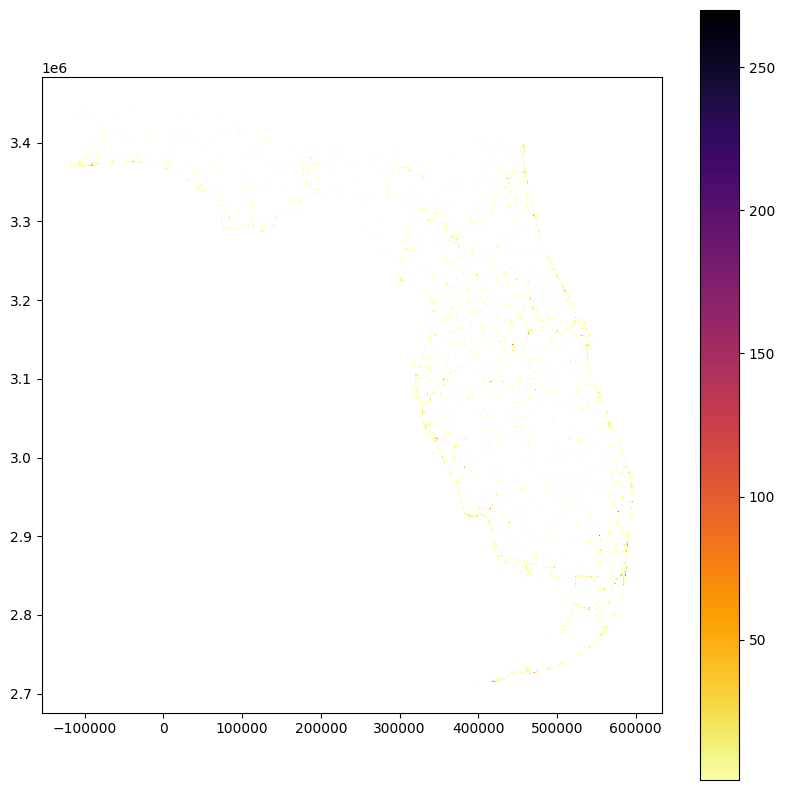

In [22]:
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearly(years_to_filter, joined_gdf_onlyHumanAct, 'OverallonlyHumanAct_201401-201912', sta=False)

In [23]:
uni_class = joined_gdf[predLabel].unique()
uni_class

array(['Wildlife_Viewing', 'Other', 'Boating', 'Landscape_Aesthetics',
       'Surfing', 'Swimming', 'Biking', 'Hiking', 'Fishing', 'Camping',
       'Shelling', 'Horseback_Riding', 'Hunting'], dtype=object)

Wildlife_Viewing 172154


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


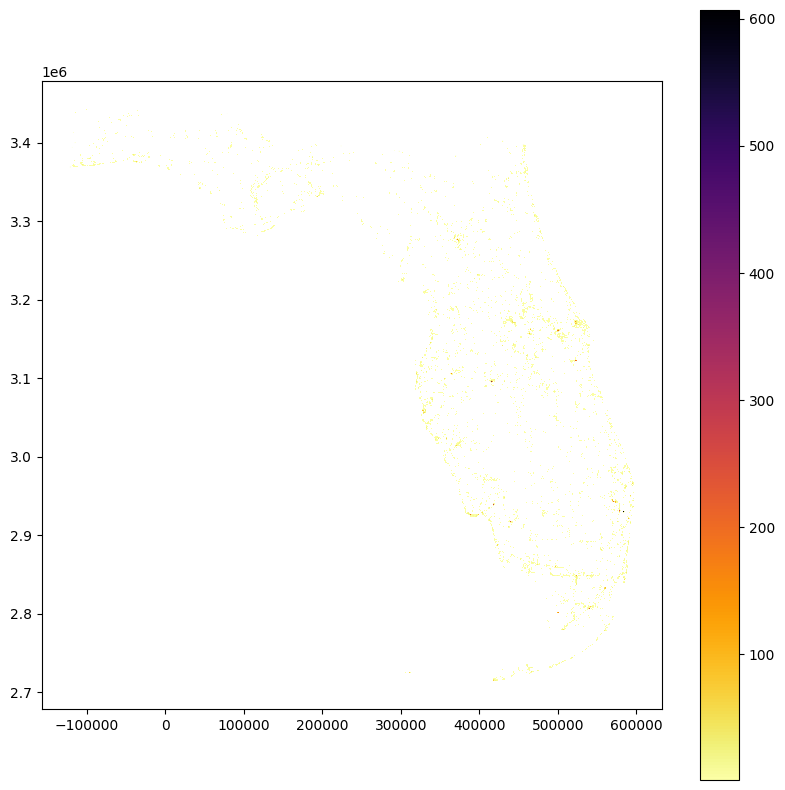

Other 279605


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


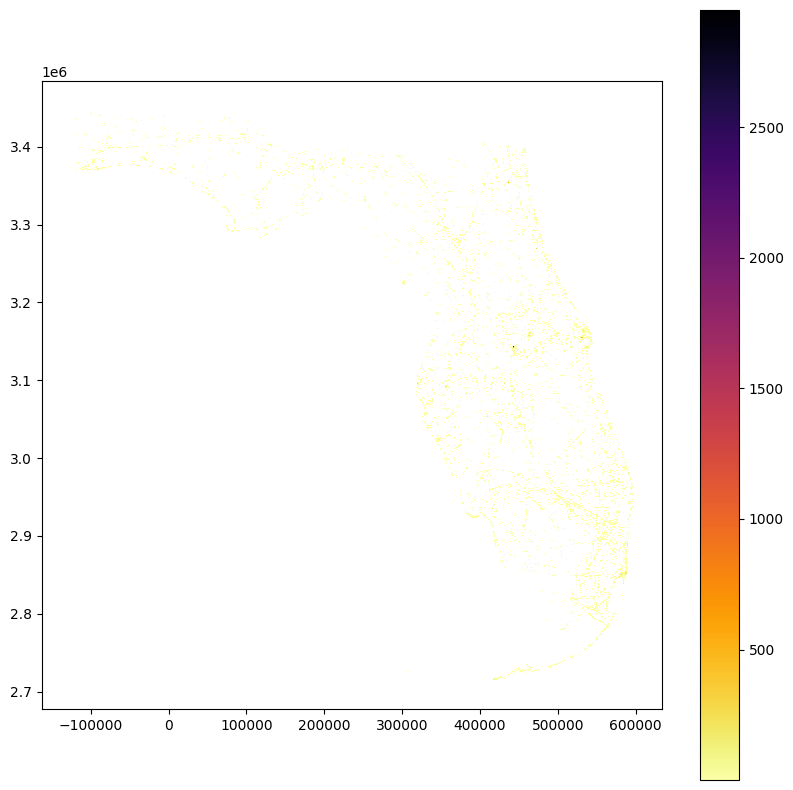

Boating 15491


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


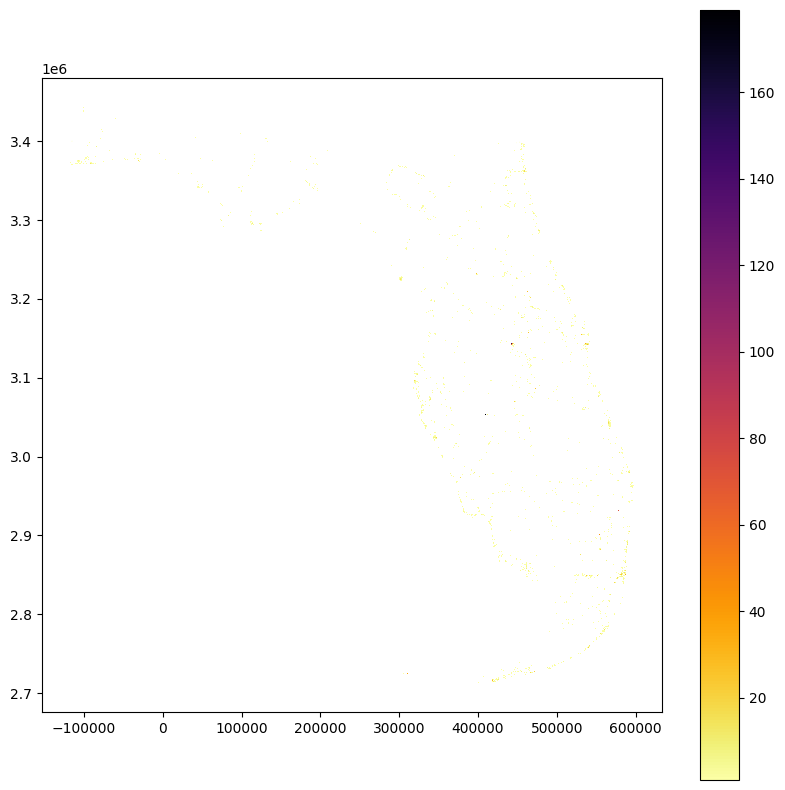

Landscape_Aesthetics 67133


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


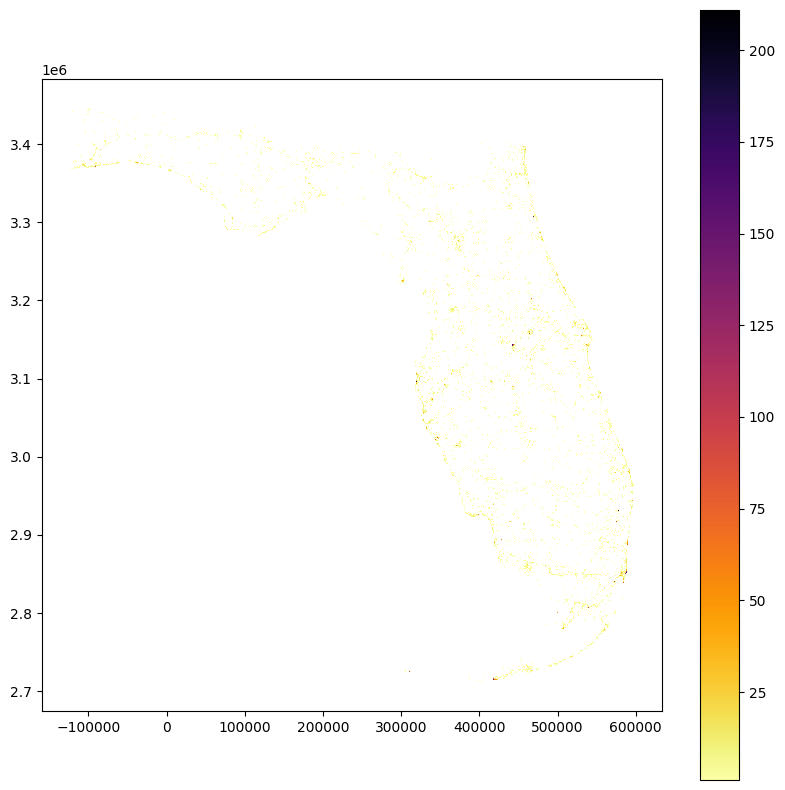

Surfing 5000


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


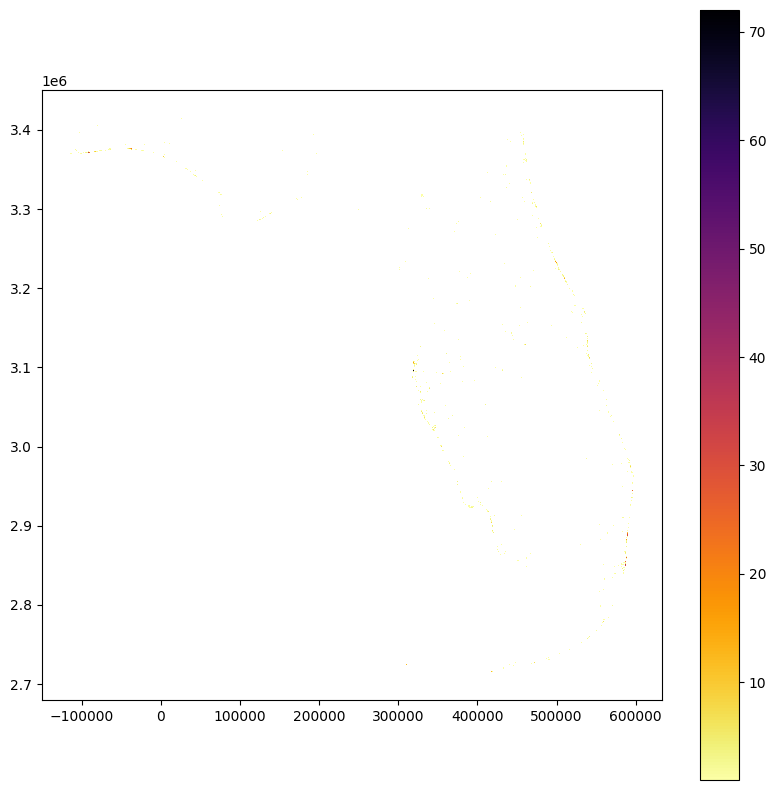

Swimming 14463


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


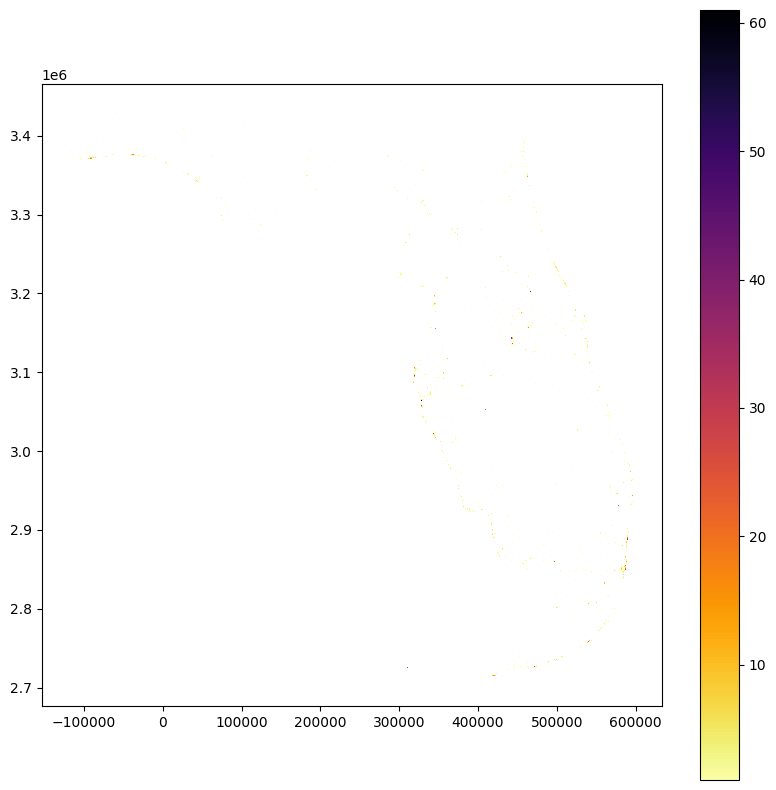

Biking 3360


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


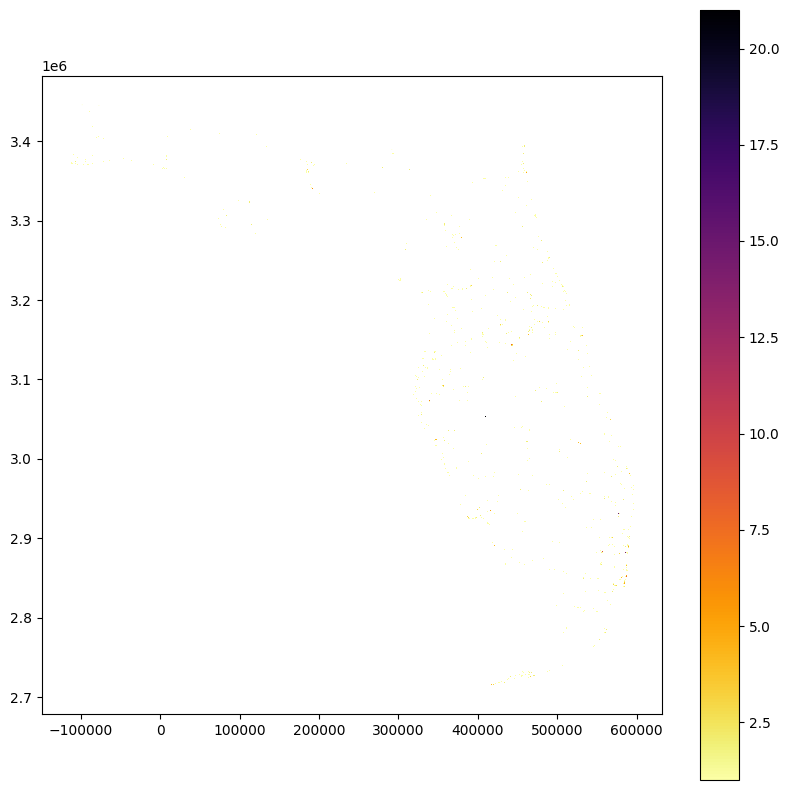

Hiking 6125


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


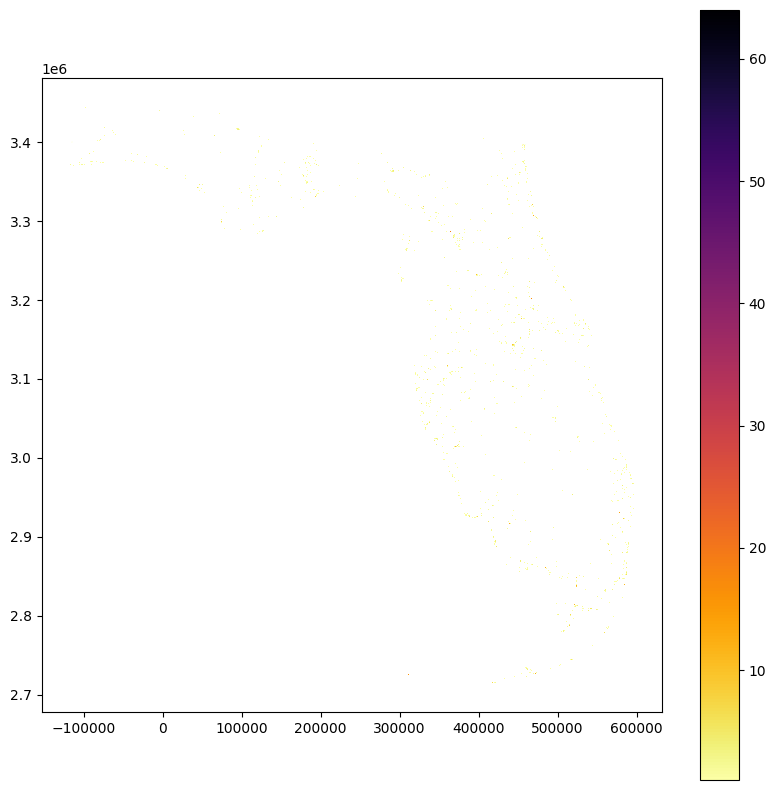

Fishing 6677


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


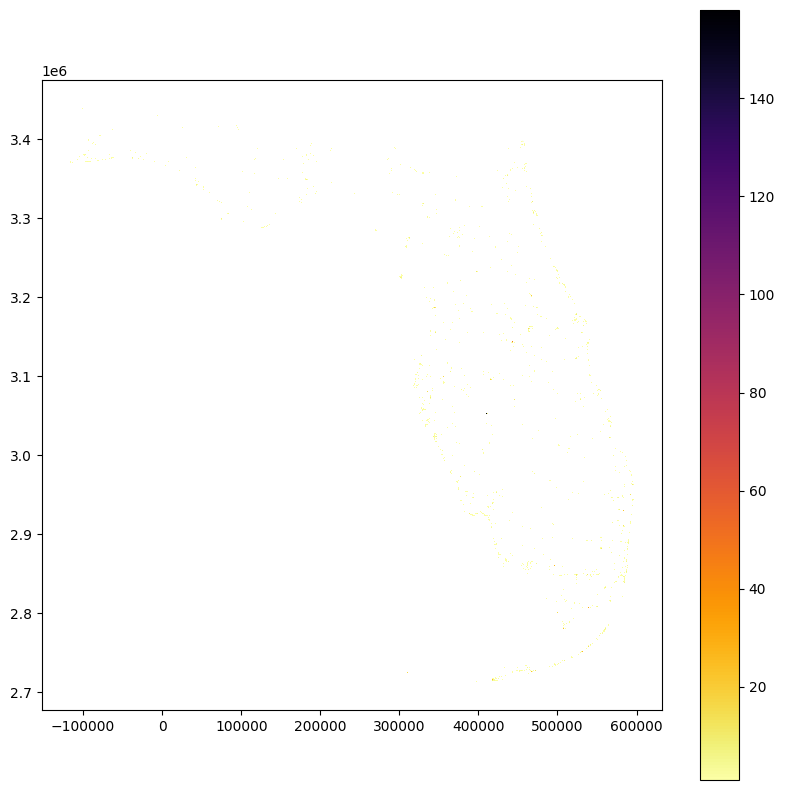

Camping 2435


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


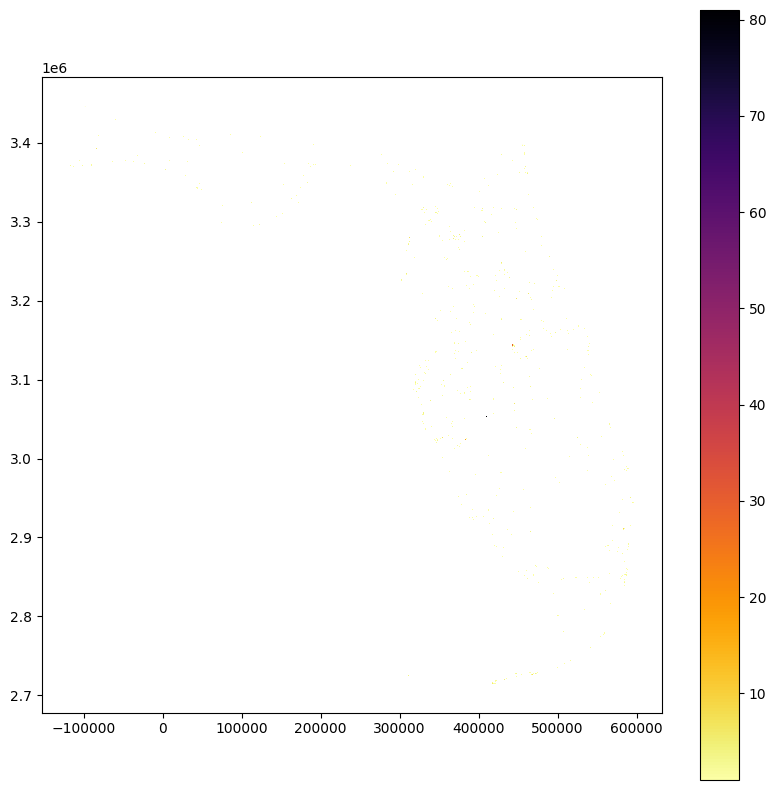

Shelling 11575


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


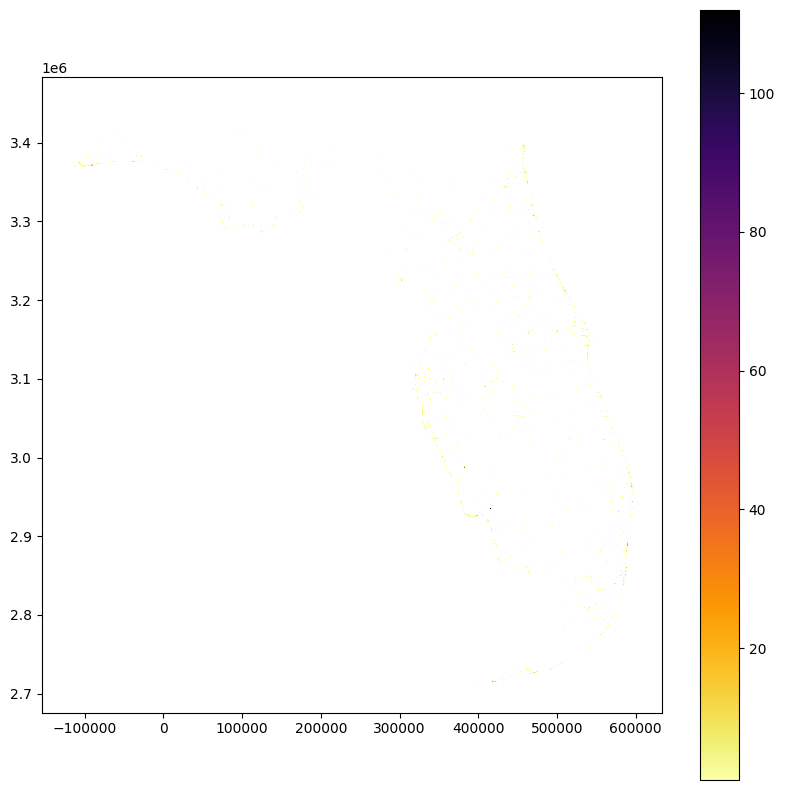

Horseback_Riding 2757


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


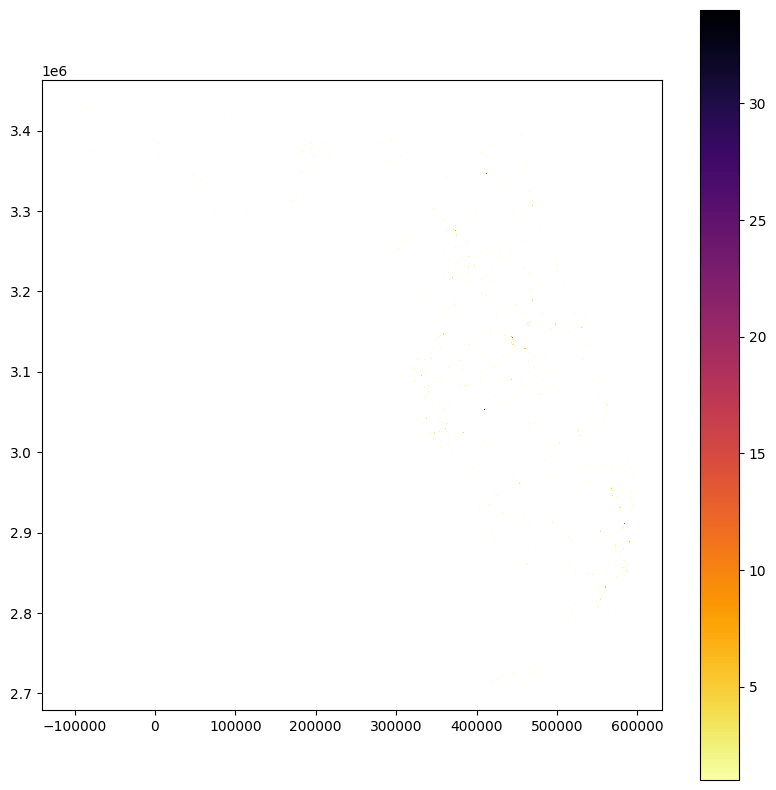

Hunting 3603


/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


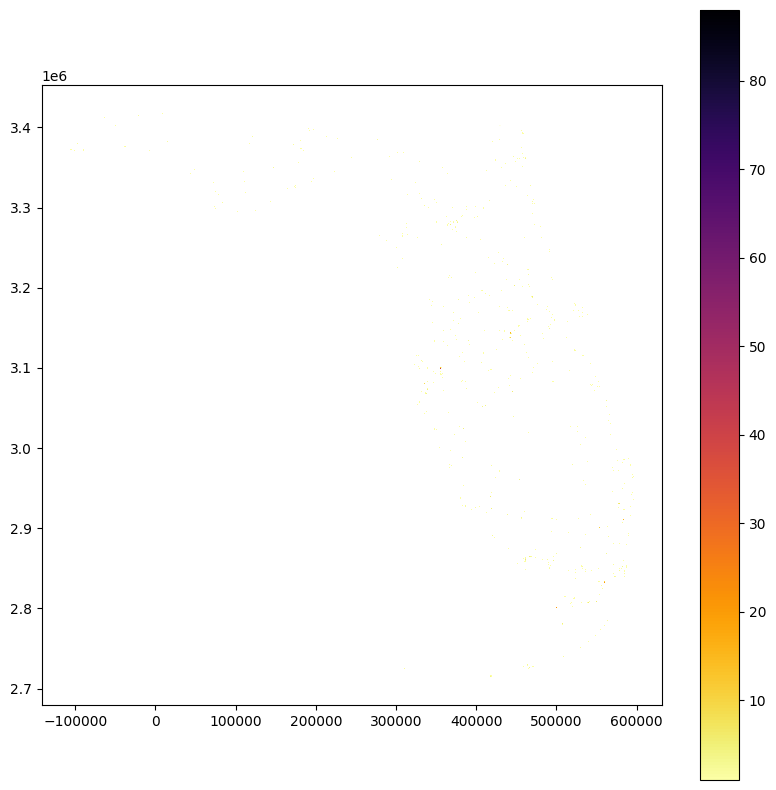

In [24]:
#Considerate each class
for cla in list(uni_class):
    joined_gdf_cla = joined_gdf[joined_gdf[predLabel]==cla]
    print(cla, len(joined_gdf_cla))
    avgPUDsyearly(years_to_filter, joined_gdf_cla, f'{cla}_201401-201912', sta=False)

/scratch/local/22543435/ipykernel_1480661/1845987027.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'unique_owner_counts' to 'unique_own'
  ogr_write(
/blue/changzhao/haoyuliao/.conda/envs/FL-CES-Flows-CLIP/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Avg_pud_des' to 'Avg_pud_de'
  ogr_write(


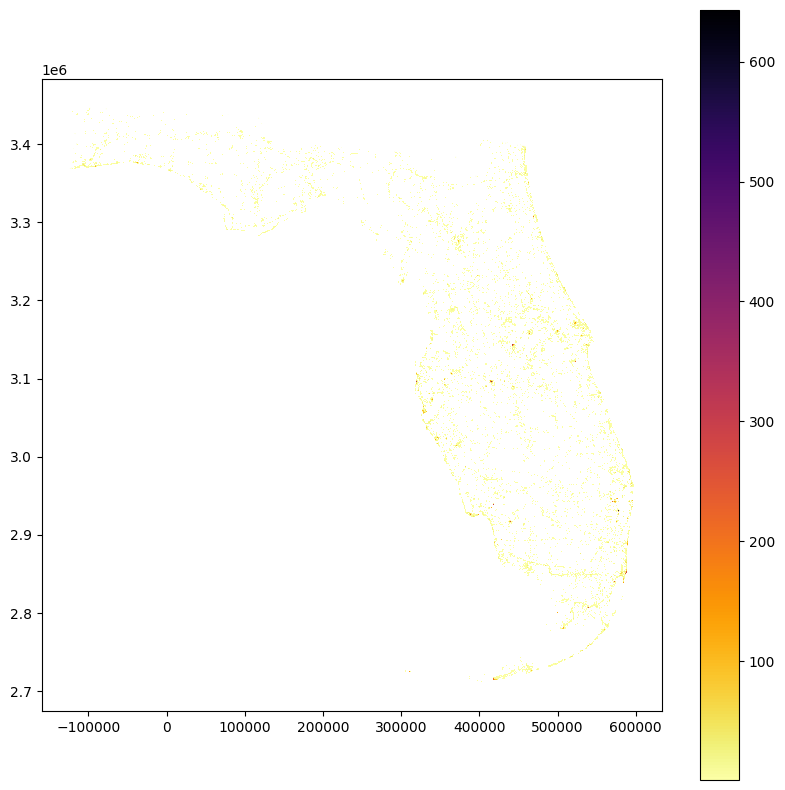

In [25]:
#Total
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearly(years_to_filter, joined_gdf_excludeNoCES, f'Total_excludeNoCES_201401-201912', sta=False)